# Homework #7 
Josh Cohen

In [1]:
import numpy as np
import sympy as sym
%matplotlib notebook
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, trapz
from scipy.optimize import minimize


## General

In [2]:
# T= 2 * np.pi
# t = sym.symbols('t')
# x = sym.Function('x')(t)
# y = sym.Function('y')(t)
# theta = sym.Function('theta')(t)
# u0 = sym.Function('u_0')(t)
# u1 = sym.Function('u_1')(t)

# u = sym.Matrix([u0,u1])
# q = sym.Matrix([x,y,theta])
# qdot = sym.Matrix([sym.cos(theta)*u[0], sym.sin(theta) * u[0], u[1]])
# q_init = np.array([0,0,np.pi])
# q_d = sym.Matrix([4/(2*sym.pi) * t, 0, sym.pi/2])
# u_init = np.array([1,-1/2])

## Problem 1
Create a function that calculates the directional derivative of a Q,R,P1 style cost function for any given trajectory and perturbation with $x_d(t)$ as desired trajectory
Evaluate the directional derivative along inital traj. with perturbation $v_1(t) = 0.05sin(t)-0.1$, $v_2(t)= 0.05cos(t)$

In [3]:
Q = sym.Matrix([[1000, 0, 0],[0, 1000, 0], [0,0,1]])
R = sym.Matrix([[100, 0],[0,1]])
P1 = sym.Matrix([[1000, 0, 0],[0, 1000, 0],[0, 0, 100]])

In [4]:
T= 2 * np.pi
t = sym.symbols('t')

x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)
x2 = sym.Function('x_2')(t)

z0 = sym.Function('z_0')(t)
z1 = sym.Function('z_1')(t)
z2 = sym.Function('z_2')(t)

x = sym.Matrix([x0, x1, x2])
z = sym.Matrix([z0, z1, z2])

x_fin = sym.MatrixSymbol('x(T)', 3, 1).as_explicit()
z_fin = sym.MatrixSymbol('z(T)', 3, 1).as_explicit()
x_init = np.array([0,0,np.pi/2])
z_init = np.zeros(3)

x_d = sym.Matrix([4/(2*sym.pi) * t, 0, sym.pi/2])
x_d_fin = x_d.subs(t, T)

u0 = sym.Function('u_0')(t)
u1 = sym.Function('u_1')(t)
v0 = sym.Function('v_0')(t)
v1 = sym.Function('v_1')(t)

u = sym.Matrix([u0,u1])
v = sym.Matrix([v0,v1])
u_init = np.array([1,-1/2])

xdot = sym.Matrix([sym.cos(x[2])*u[0], sym.sin(x[2]) * u[0], u[1]])

A = xdot.jacobian(x)
B = xdot.jacobian(u)

In [5]:
def get_v():
    v = sym.Matrix([-0.5 * sym.sin(t) - 0.1, 0.5*sym.cos(t)])
#     v = sym.Matrix([ 0.05*sym.cos(t),0.05 * sym.sin(t) - 0.1])
    
    return v

In [6]:
R = np.array(R)
Q = np.array(Q)
P1 = np.array(P1)
#args:
#    x_init - intitial x,y,theta Nx1
#    x_d_traj - desired trajectory Nx1xD
#    u_traj - effort Nx1xD
#    t_vec - time vector 1xD
#    get_v - function that returns symbolic v 


def compute_dd_for_perturb(x_init,x_d_traj,u_traj,t_vec,get_v):
    v = get_v()
    u_init = u_traj[:,0]
    zdot = A * z + B * v
    
    q = sym.Matrix([z, x])
    qdot = sym.Matrix([zdot, xdot]).subs({u[0]:u_init[0], u[1]:u_init[1]})
#     display(qdot)
    q_init = np.concatenate((z_init, x_init))
    
    qdot_lam = sym.lambdify([t, q], sym.flatten(qdot))
    ans = solve_ivp(qdot_lam, (0, T), q_init, t_eval=t_vec)

    zed = ans.y[:3,:]
    x_traj = ans.y[3:,:]
    t_vec = ans.t
    v_lam = sym.lambdify(t,v)
    ved = np.squeeze(v_lam(t_vec))
    
    J_dd_integrand = np.zeros(t_vec.shape[0])
    for i in range(t_vec.shape[0]):
        J_dd_integrand[i] = np.matmul(np.matmul((x_traj[:,i] - x_d_traj[:,i]).T, Q), zed[:,i]) \
                                        + np.matmul(np.matmul(u_traj[:,i].T, R), ved[:,i])
    
    J_dd_term = np.matmul(np.matmul((x_traj[:,-1] - x_d_traj[:,-1]).T, P1), zed[:,-1])

    J_dd_val = trapz(J_dd_integrand, t_vec) + J_dd_term
    
    return J_dd_val, zed, x_traj

In [7]:
t_vec = np.linspace(0,T,1000)
x_to_dd = np.repeat(np.expand_dims(x_init,1), t_vec.shape[0], axis=1)
u_to_dd = np.repeat(np.expand_dims(u_init,1), t_vec.shape[0], axis=1)

x_0_d_gen = sym.lambdify([t], x_d[0])
x_0_d = np.expand_dims(x_0_d_gen(t_vec),0)
x_12 = np.array([[0,np.pi/2]]).T
x_12_d = np.repeat(x_12, t_vec.shape[0], axis=1)
x_d_to_dd = np.concatenate((x_0_d, x_12_d))

x_d_traj = x_d_to_dd
u_traj = u_to_dd
# qdot = sym.Matrix([zdot, xdot])
# q_init = np.concatenate((z_init, x_init))

In [8]:
J_dd, zed, xed = compute_dd_for_perturb(x_init, x_d_to_dd, u_to_dd, t_vec, get_v)
J_dd

-4248.40865525442

<IPython.core.display.Javascript object>


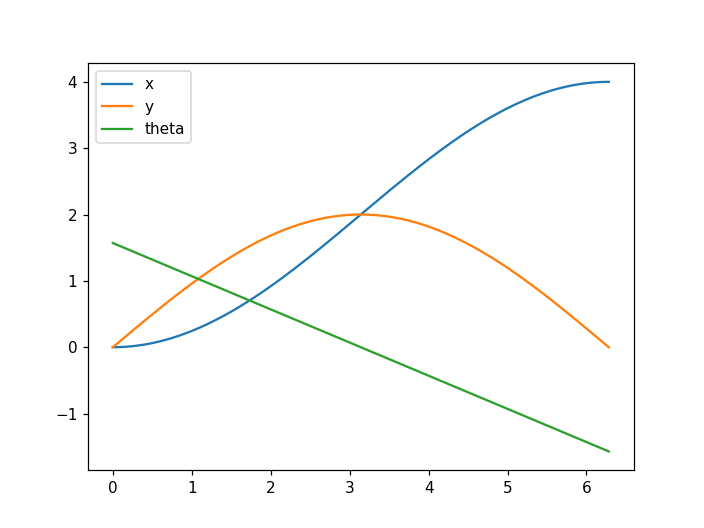

In [9]:
plt.figure()
plt.plot(t_vec, xed[0,:])
plt.plot(t_vec, xed[1,:])
plt.plot(t_vec, xed[2,:])
plt.legend(["x", "y", "theta"])
plt.show()

In [ ]:
plt.figure()
plt.plot(t_vec, zed[0,:])
plt.plot(t_vec, zed[1,:])
plt.plot(t_vec, zed[2,:])
plt.legend(["x", "y", "theta"])
plt.show()

## Problem #2
Create a function that performs the Armijo line search for the diff drive vehichle. Determine optimal step size for the descent direction defined by $v_1(t), v_2(t)$ and the inital semi circle traj defined by $u_1(t) = 1, u_2(t)=\frac{-1}{2}$. 

In [10]:
J_integrand = (x - x_d).T * Q * (x - x_d) + u.T * R * u
J_int_lam = sym.lambdify([t, x, u], sym.flatten(J_integrand))
def J(psi, x_d=x_d_traj, t_span=t_vec):
    x = psi[:3,:]
    u = psi[3:,:]
    N = t_span.shape[0]
    J_int = np.zeros(N)
    for i,t in zip(range(N),t_span):
        J_int[i] = J_int_lam(t, x[:,i], u[:,i])[0]
        
    J_term = np.matmul(np.matmul((x[:,-1] - x_d[:,-1]).T, P1), (x[:,-1] - x_d[:,-1]))
    J_val = trapz(J_int, t_span) + J_term
    
    return float(J_val)

In [11]:
def J_dd_z(psi,zeta, x_d_traj=x_d_traj,t_vec=t_vec):
    x_traj = psi[:3,:]
    u_trak = psi[3:,:]
    zed = zeta[:3,:]
    ved = zeta[3:,:]
    
    J_dd_integrand = np.zeros(t_vec.shape[0])
    for i in range(t_vec.shape[0]):
        J_dd_integrand[i] = np.matmul(np.matmul((x_traj[:,i] - x_d_traj[:,i]).T, Q), zed[:,i]) \
                                        + np.matmul(np.matmul(u_traj[:,i].T, R), ved[:,i])
    
    J_dd_term = np.matmul(np.matmul((x_traj[:,-1] - x_d_traj[:,-1]).T, P1), zed[:,-1])

    J_dd_val = trapz(J_dd_integrand, t_vec) + J_dd_term
    
    return float(J_dd_val)

In [12]:
alpha = 0.4
beta = 0.7 
eps = 0.05
iter_count = 0
# vals = np.zeros(t_vec.shape[0])
# vals[iter_count] = J(x_i)

In [13]:
n = 0
gam = beta**n
x_i = np.vstack((xed,u_traj))
ved = np.squeeze(sym.lambdify(t, get_v())(t_vec))
z_i = np.vstack((zed,ved))
# np.linalg.norm(J(x_i + gam * z_i))

In [14]:
def suff_compare(x_i, z_i, gam):
    return J(x_i) + alpha * gam * J_dd_z(x_i,z_i)

In [26]:
n = 0
gam = beta**n
psi = sym.Matrix([x,u])
x_i = np.vstack((xed,u_traj))
z_i = np.vstack((zed,ved))
while np.linalg.norm(J(x_i + gam * z_i)) > np.linalg.norm(suff_compare(x_i, z_i, gam)):
    ued = u_init.reshape(2,1) + gam * get_v()
    udot = ued.diff(t)
    psidot = sym.lambdify([t, psi], sym.flatten(sym.Matrix([xdot,udot])))
    psi_init = np.concatenate((x_init, np.squeeze(ued.subs(t,0))))
    x_i = solve_ivp(psidot, (0, T), psi_init, t_eval=t_vec).y
    print(n)
    n += 1
    gam = beta**n

print(gam)

0
1
2
3
4
5
6
0.08235429999999996


In [ ]:
n = 0
gam = beta**n
x_i = np.vstack((xed,ued))
z_i = zeta
psi = sym.Matrix([x,u])

In [ ]:
ued = u_init.reshape(2,1) + 1 * get_v()
udot = ued.diff(t)
psi = sym.Matrix([x,u])
psidot = sym.Matrix([xdot,udot])
psi_init = np.concatenate((x_init, u_init))
psidot_lam = sym.lambdify([t, psi], sym.flatten(psidot))
ans_psi = solve_ivp(psidot_lam, (0,T), psi_init)

In [ ]:
ans_psi.y.shape

In [ ]:
np.squeeze(ued.subs(t,0)).shape